# FWI in the Cloud with Devito

In [1]:
# If you have not already done so
# pip install --upgrade google-cloud-storage

from google.cloud import storage

import os
from pathlib import Path

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/ggorman/Downloads/seg-demo-project-2-2fa1703fb1c7.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/jovyan/seg-demo-project-2-2fa1703fb1c7.json"

def download_file_from_bucket(filename):    
    client = storage.Client(project='seg-demo-project-2')
    bucket = client.get_bucket('datasets-proxy')
    blob = bucket.get_blob(filename)
    with open(filename, 'wb') as f:
        blob.download_to_file(f)

def upload_file_to_bucket(filename):
    client = storage.Client(project='seg-demo-project-2')
    bucket = client.get_bucket('datasets-proxy')
    blob = storage.Blob(filename, bucket)
    with open(filename, 'rb') as f:
        blob.upload_from_file(f)

In [2]:
import h5py

def from_hdf5(filename, **kwargs):
    f = h5py.File(filename, 'r')
    
    origin = kwargs.pop('origin', None)
    if origin is None:
        origin_key = kwargs.pop('origin_key', 'o')
        origin = tuple(f[origin_key][()])

    spacing = kwargs.pop('spacing', None)
    if spacing is None:
        spacing_key = kwargs.pop('spacing_key', 'd')
        spacing = tuple(f[spacing_key][()])
        
    nbpml = kwargs.pop('nbpml', 20)
    datakey = kwargs.pop('datakey', None)
    if datakey is None:
        raise ValueError("datakey must be known - what is the name of the data in the file?")
    
    space_order=kwargs.pop('space_order', None)
    dtype = kwargs.pop('dtype', None)
    data_m = f[datakey][()]
    data_vp = np.sqrt(1/data_m).astype(dtype)
    data_vp = np.transpose(data_vp, (1, 2, 0))
    shape = data_vp.shape
    
    f.close()
    
    return Model(space_order=space_order, vp=data_vp, origin=origin, shape=shape,
                 dtype=dtype, spacing=spacing, nbpml=nbpml)

## Introduction

In this tutorial we show how [Devito](http://www.opesci.org/devito-public) and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) are used with [Dask](https://dask.pydata.org/en/latest/#dask) to perform [full waveform inversion](https://www.slim.eos.ubc.ca/research/inversion) (FWI) on distributed memory parallel computers.

## scipy.optimize.minimize 

In this tutorial we use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to solve the FWI gradient based minimization problem rather than the simple grdient decent algorithm in the previous tutorial.

```python
scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
```

> Minimization of scalar function of one or more variables.
>
> In general, the optimization problems are of the form:
>
> minimize f(x) subject to
>
> g_i(x) >= 0,  i = 1,...,m
> h_j(x)  = 0,  j = 1,...,p
> where x is a vector of one or more variables. g_i(x) are the inequality constraints. h_j(x) are the equality constrains.

[scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) provides a wide variety of methods for solving minimization problems depending on the context. Here we are going to focus on using L-BFGS via [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb)

```python
scipy.optimize.minimize(fun, x0, args=(), method='L-BFGS-B', jac=None, bounds=None, tol=None, callback=None, options={'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})```

The argument `fun` is a callable function that returns the misfit between the simulated and the observed data. If `jac` is a Boolean and is `True`, `fun` is assumed to return the gradient along with the objective function - as is our case when applying the adjoint-state method.

## What is Dask?

> [Dask](https://dask.pydata.org/en/latest/#dask) is a flexible parallel computing library for analytic computing.
>
> Dask is composed of two components:
>
> * Dynamic task scheduling optimized for computation...
> * “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of the dynamic task schedulers.
>
> Dask emphasizes the following virtues:
> 
> * Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
> * Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
> * Native: Enables distributed computing in Pure Python with access to the PyData stack.
> * Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
> * Scales up: Runs resiliently on clusters with 1000s of cores
> * Scales down: Trivial to set up and run on a laptop in a single process
> * Responsive: Designed with interactive computing in mind it provides rapid feedback and diagnostics to aid humans

**We are going to use it here to parallelise the computation of the functional and gradient as this is the vast bulk of the computational expense of FWI and it is trivially parallel over data shots.**

## Setting up (synthetic) data
In a real world scenario we work with collected seismic data; for the tutorial we know what the actual solution is and we are using the workers to also generate the synthetic data.

In [3]:
#NBVAL_IGNORE_OUTPUT

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 4000.,              # Simulation last 4 second (4000 ms)
         'f0': 0.008,              # Source peak frequency is 5Hz (0.005 kHz)
         'nshots': 97**2,          # Number of shots to create gradient from
         'm_bounds': (0.08, 0.25), # Set the min and max slowness
         'nbpml': 40}              # nbpml thickness.

import numpy as np

import scipy
from scipy import signal, optimize

from devito import Grid

from distributed import Client, LocalCluster, wait

import cloudpickle as pickle

# Import acoustic solver, source and receiver modules.
from examples.seismic import Model, demo_model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import TimeAxis, PointSource, RickerSource, Receiver

# Import convenience function for plotting results
from examples.seismic import plot_image

In [4]:
def get_true_model():
    filename = 'overthrust_3D_true_model.h5'
    
    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)
        
    return from_hdf5(filename, nbpml=param['nbpml'], space_order=4,
                     datakey='m', dtype=np.float32)

def get_initial_model():
    filename = 'overthrust_3D_initial_model.h5'
    
    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)
    
    return from_hdf5(filename, nbpml=param['nbpml'], space_order=4,
                     datakey='m0', dtype=np.float32)

In [5]:
initial_model = get_initial_model()

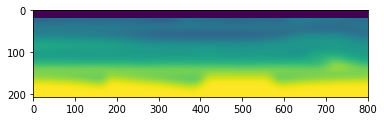

In [6]:
import matplotlib.pyplot as plt

plt.imshow(initial_model.vp[500, :, :].transpose())

In [ ]:
true_model = get_true_model()

In [ ]:
param['shape'] = true_model.vp.shape
param['spacing'] = true_model.spacing
param['origin'] = true_model.origin

plt.imshow(true_model.vp[500, :, :].transpose())


In [ ]:
def load_model(filename):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """

    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)

    pkl = pickle.load(open(filename, "rb"))
    
    return pkl['model']

def dump_model(filename, model):
    ''' Dump model to disk.
    '''
    pickle.dump({'model':model}, open(filename, "wb"))
    
    upload_file_to_bucket(filename)

In [ ]:
def load_shot_data(shot_id, dt):
    ''' Load shot data from disk, resampling to the model time step.
    '''
    filename = "shot_%d.p"%shot_id
    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)
    
    pkl = pickle.load(open(filename, "rb"))
    
    return pkl['src'].resample(dt), pkl['rec'].resample(dt)

def dump_shot_data(shot_id, src, rec):
    ''' Dump shot data to disk.
    '''
    filename = 'shot_%d.p'%shot_id
    pickle.dump({'src':src, 'rec':rec}, open(filename, "wb"))

    upload_file_to_bucket(filename)

In [ ]:
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    true_model = get_true_model()
    shot_id = param['shot_id']
    
    i = shot_id%97
    j = int(shot_id/97)
    
    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Set up source data and geometry.
    time_range = TimeAxis(start=param['t0'], stop=param['tn'], step=dt)
    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'],
                       time_range=time_range)

    src.coordinates.data[0, :] = [400+i*true_model.spacing[0], 400+j*true_model.spacing[1], 50] 
    
    # Number of receiver locations per shot.
    nreceivers = 384**2

    # Set up receiver data and geometry.
    rec = Receiver(name='rec', grid=true_model.grid, time_range=time_range,
                   npoint=nreceivers)
    
    for n in range(384):
        for m in range(384):
            rec.coordinates.data[:, 0] = 400+n*true_model.spacing[0]
            rec.coordinates.data[:, 1] = 400+m*true_model.spacing[1]
            rec.coordinates.data[:, 2] = 50

    # Set up solver.
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model.
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    dump_shot_data(shot_id, src, true_d)

def generate_shotdata(param):
    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Map worklist to cluster
    futures = client.map(generate_shotdata_i, work)

    print("Distributed work - now waiting for everyone to finish")
        
    # Wait for all futures
    wait(futures)
    print("Finished generating shot data")

In [ ]:
param['shot_id'] = 1
generate_shotdata_i(param)

In [ ]:
#NBVAL_IGNORE_OUTPUT

# Start Dask cluster
client = Client()

# Generate shot data.
generate_shotdata(param)

## Dask specifics

Previously we defined a function to calculate the individual contribution to the functional and gradient for each shot, which was then used in a loop over all shots. However, when using distributed frameworks such as Dask we instead think in terms of creating a worklist which gets *mapped* onto the worker pool. The sum reduction is also performed in parallel. For now however we assume that the scipy.optimize.minimize itself is running on the *master* process; this is a reasonable simplification because the computational cost of calculating (f, g) far exceeds the other compute costs.

Because we want to be able to use standard reduction operators such as sum on (f, g) we first define it as a type so that we can define the `__add__` (and `__rand__` method).

In [ ]:
# Define a type to store the functional and gradient.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

## Create operators for gradient based inversion
To perform the inversion we are going to use [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb).

First we define the functional, ```f```, and gradient, ```g```, operator (i.e. the function ```fun```) for a single shot of data. This is the work that is going to be performed by the worker on a unit of data.

In [ ]:
from devito import Function

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):
    from devito import clear_cache

    # Need to clear the workers cache.
    clear_cache()

    # Load the current model and the shot data for this worker.
    # Note, unlike the serial example the model is not passed in
    # as an argument. Broadcasting large datasets is considered
    # a programming anti-pattern and at the time of writing it
    # it only worked relaiably with Dask master. Therefore, the
    # the model is communicated via a file.
    model0 = load_model(param['model'])
    
    dt = model0.critical_dt

    src, rec = load_shot_data(param['shot_id'], dt)

    # Set up solver.
    solver = AcousticWaveSolver(model0, src, rec, space_order=4)

    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data misfit (residual) and objective function
    residual = Receiver(name='rec', grid=model0.grid,
                        time_range=rec.time_range,
                        coordinates=rec.coordinates.data)

    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropagates the data misfit through the model.
    grad = Function(name="grad", grid=model0.grid)
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Copying here to avoid a (probably overzealous) destructor deleting
    # the gradient before Dask has had a chance to communicate it.
    g = np.array(grad.data[:])
    
    # return the objective functional and gradient.
    return fg_pair(f, g)



Define the global functional-gradient operator. This does the following:
* Maps the worklist (shots) to the workers so that the invidual contributions to (f, g) are computed.
* Sum individual contributions to (f, g) and returns the result.

In [ ]:
def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.p"
    dump_model(param['model'], model)

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Distribute worklist to workers.
    fgi = client.map(fwi_gradient_i, work, retries=1)
    
    # Perform reduction.
    fg = client.submit(sum, fgi).result()
    
    return fg.f, fg.g

## FWI

Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [ ]:
from scipy import optimize

fwi_iterations = 5
model0 = get_initial_model()

# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(m, 1/3.5**2, 1/2**2)

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .005 / np.max(direction)
    
    # Update the model estimate and inforce minimum/maximum values
    model0.m.data[:] = apply_box_constraint(model0.m.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

We now apply our FWI function and have a look at the result.

In [ ]:
#NBVAL_SKIP

# Show what the update does to the model
from examples.seismic import plot_image, plot_velocity

model0.vp = np.sqrt(1. / model0.m.data[40:-40, 40:-40])
plot_velocity(model0)

In [ ]:
#NBVAL_SKIP

# Plot percentage error
plot_image(100*np.abs(model0.vp-get_true_model().vp.data)/get_true_model().vp.data, vmax=15, cmap="hot")

In [ ]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_error)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>